In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times"] + plt.rcParams["font.serif"]
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'Serif'
mpl.rcParams['mathtext.it'] = 'Serif'
mpl.rcParams['mathtext.bf'] = 'Serif'
mpl.rcParams['text.usetex']= False
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')

In [3]:
def get_data(logs_dir):
    freqs = []
    profs = []
    n_profs = []
    # prof_index = pd.read_table(f"{logs_dir}/profiles.index", skiprows=1, sep='\s+')
    prof_index = np.loadtxt(f"{logs_dir}/profiles.index", skiprows=1, dtype=int)

    for f in sorted(glob.glob(f"{logs_dir}/profile*.data.GYRE"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1])):
        profs.append(pd.read_table(f, skiprows=5, sep='\s+'))

    for f in sorted(glob.glob(f"{logs_dir}/profile*-freqs.dat"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1].split('-')[0])):
        freqs.append(pd.read_table(f, skiprows=5, sep='\s+'))
        n_profs.append(int(f.split('profile')[-1].split('-')[0]))
    hist = pd.read_table(glob.glob(f"{logs_dir}/history.data")[0], skiprows=5, sep='\s+')

    return hist, freqs, profs, n_profs, prof_index

# hist, freqs, profs, n_profs, prof_index = get_data("tests_here/test_M1.5_Z0.01/LOGS")
# n_profs

In [4]:
def fit_radial(ts, degree=0):
    """
    Fits a straight line to the radial mode frequencies. Optionally, can be used on non-radial modes.
    Only modes with radial orders 5-9 are used, as the ridges should be vertical here.
    
    Input: Theoretical (or observed) spectrum in pandas df format; mode degree to be used (default 0 = radial)
    Output: The length of the series used, and the slope, intercept, r_value, p_value, and std_err of the line.
    """
    n_min, n_max = 5, 9
    try:
        vert_freqs = ts.query("n_g == 0").query(f"l=={degree}").query(f"n_pg>={n_min}").query(f"n_pg<={n_max}")[["n_pg","Re(freq)"]].values
    except:
        vert_freqs = ts.query(f"l_obs=={degree}").query(f"n_obs>={n_min}").query(f"n_obs<={n_max}")[["n_obs","f_obs"]].values
    if len(vert_freqs>0):
        slope, intercept, r_value, p_value, std_err = linregress(vert_freqs[:,0], vert_freqs[:,1])
    else:
        slope, intercept, r_value, p_value, std_err = np.zeros(5)
    return len(vert_freqs), slope, intercept, r_value, p_value, std_err

def model_epsilon(ts):
    """
    Calls the fit_radial function to determine the epsilon value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Epsilon
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    eps = intercept/slope
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_dip > length_rad:
            eps = intercept/slope - 0.5 # take the ell=1 values and subtract 0.5 to equal epsilon (ell=0)
    return np.round(eps, 3)

def model_Dnu(ts):
    """
    Calls the fit_radial function to determine the Delta nu value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Delta nu
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_rad > length_dip:
            # redo radial
            length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    Dnu = slope
    return np.round(Dnu, 3)

def get_fit(l, freq):
    Dnu = model_Dnu(freq)
    epsilon = model_epsilon(freq)
    return Dnu, epsilon


In [27]:
M_sample = [1.4, 2]
Z_sample = [0.002, 0.025]
V_sample = [0]
nets = ["basic", "cno_extras", "hot_cno", "pp_and_cno_extras", "pp_extras"]

combinations = list(itertools.product(M_sample, Z_sample, V_sample, nets))

data_dict = {}

k = 0
for m, z, v, net in combinations:
    print(m, z, v, net)
    key = f"M={m}_Z={z}_V={v}_net={net}"
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[k])
    data_dict[key] = {}
    data_dict[key]['age'] = hist['star_age']/1e6
    data_dict[key]['cno'] = hist['cno'].values
    data_dict[key]['pp'] = hist['pp'].values
    data_dict[key]['L_nuc'] = hist['log_Lnuc'].values
    data_dict[key]['density'] = hist['log_cntr_Rho'].values
    k += 1

1.4 0.002 0 basic
1.4 0.002 0 cno_extras
1.4 0.002 0 hot_cno
1.4 0.002 0 pp_and_cno_extras
1.4 0.002 0 pp_extras
1.4 0.025 0 basic
1.4 0.025 0 cno_extras
1.4 0.025 0 hot_cno
1.4 0.025 0 pp_and_cno_extras
1.4 0.025 0 pp_extras
2 0.002 0 basic
2 0.002 0 cno_extras
2 0.002 0 hot_cno
2 0.002 0 pp_and_cno_extras
2 0.002 0 pp_extras
2 0.025 0 basic
2 0.025 0 cno_extras
2 0.025 0 hot_cno
2 0.025 0 pp_and_cno_extras
2 0.025 0 pp_extras


In [28]:
def interp(x, y, age):
    f_linear = interp1d(x, y, bounds_error=False, fill_value=0)
    return f_linear(age)

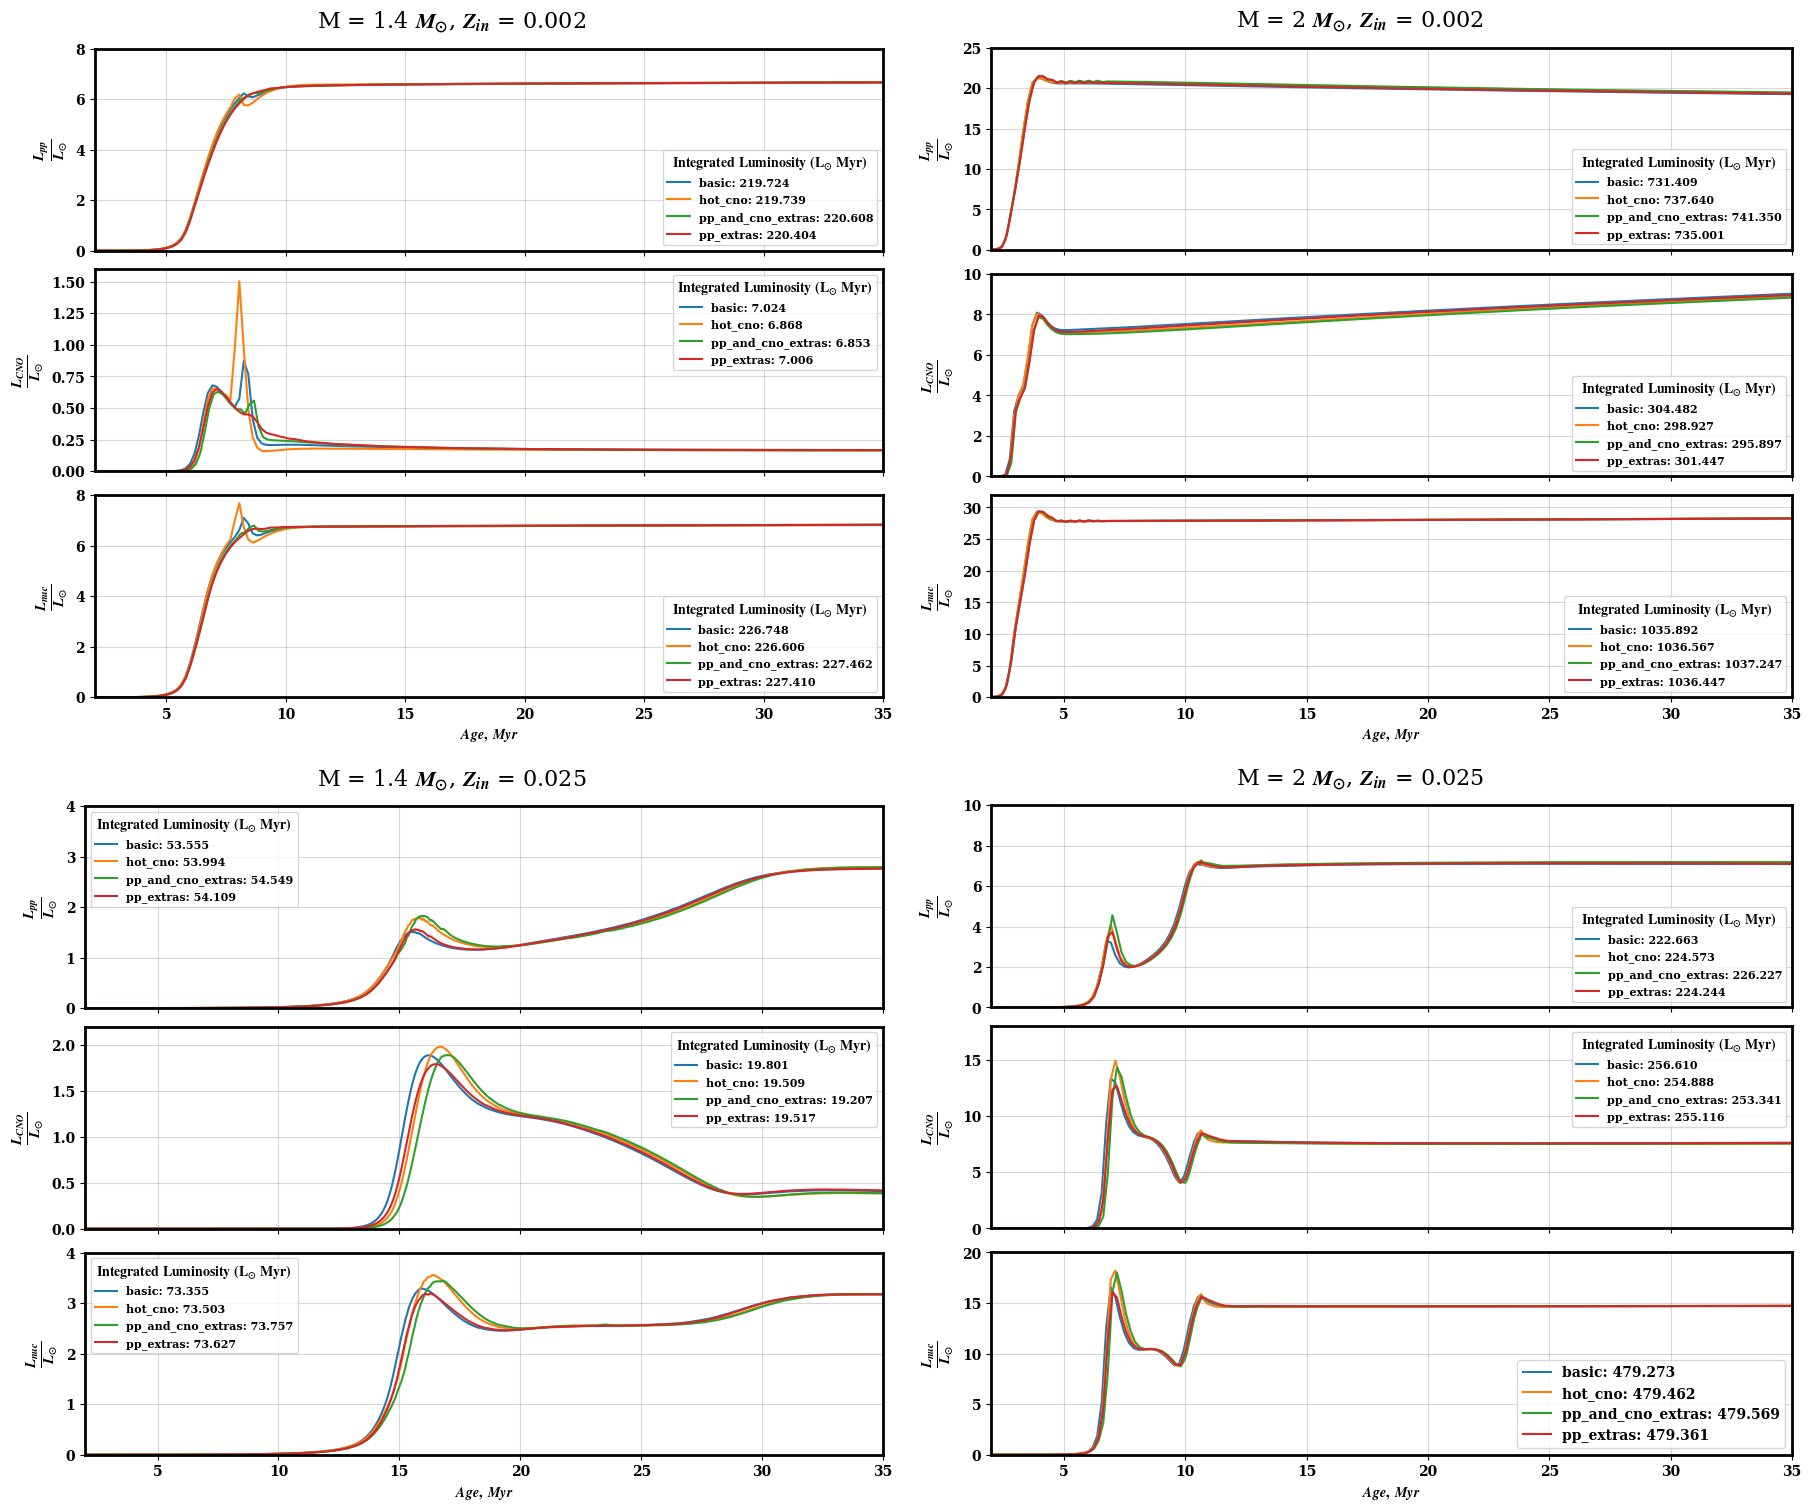

In [40]:
fig = plt.figure(constrained_layout=True, figsize=(18, 15))

subfigs = fig.subfigures(2, 2).flat

fig_names = [
    r"M = 1.4 $M_{\odot}$, $Z_{in}$ = 0.002",
    r"M = 2 $M_{\odot}$, $Z_{in}$ = 0.002",
    r"M = 1.4 $M_{\odot}$, $Z_{in}$ = 0.025",
    r"M = 2 $M_{\odot}$, $Z_{in}$ = 0.025"
]

axes = []
for o in range(4):
    subfigs[o].suptitle(fig_names[o], fontsize=16)
    axes.append(subfigs[o].subplots(3, 1))

nets = ["basic", "hot_cno", "pp_and_cno_extras", "pp_extras"]
# nets = ["cno_extras", "hot_cno"]
for fig_name in fig_names:
    m, z = fig_name.split(",")[0].split("=")[1].split()[0], fig_name.split(",")[1].split("=")[1].split()[0]
    for net in nets:
        key = f"M={m}_Z={z}_V={0}_net={net}"
        data = data_dict[key]
        for i, ax in enumerate(axes[fig_names.index(fig_name)].flat):
            if i == 0:
                age, L_pp = data['age'], 10 ** np.array(data['pp'])
                area = np.trapz(L_pp[1:], age[1:])
                ax.plot(age, L_pp, label=f"{net}: {area:.3f}")
                ax.set_ylabel(r'$\frac{L_{pp}}{L_{\odot}}$', fontsize=15)
                ax.set_xticklabels([])
                if m == "1.4":
                    if z == "0.002":
                        ax.set_ylim(0, 8)
                    elif z == "0.025":
                        ax.set_ylim(0, 4)
                elif m == "2":
                    if z == "0.002":
                        ax.set_ylim(0, 25)
                    elif z == "0.025":
                        ax.set_ylim(0, 10)
            elif i == 1:
                age, L_cno = data['age'], 10 ** np.array(data['cno'])
                area = np.trapz(L_cno[1:], age[1:])
                ax.plot(age, L_cno, label=f"{net}: {area:.3f}")
                ax.set_ylabel(r'$\frac{L_{CNO}}{L_{\odot}}$', fontsize=15)
                ax.set_xticklabels([])
                if m == "1.4":
                    if z == "0.002":
                        ax.set_ylim(0, 1.6)
                    elif z == "0.025":
                        ax.set_ylim(0, 2.2)
                elif m == "2":
                    if z == "0.002":
                        ax.set_ylim(0, 10)
                    elif z == "0.025":
                        ax.set_ylim(0, 18)
            elif i == 2:
                age, L_nuc = data['age'], 10 ** np.array(data['L_nuc'])
                area = np.trapz(L_nuc[1:], age[1:])
                ax.plot(age, L_nuc, label=f"{net}: {area:.3f}")
                # ax.plot(age, L_nuc, label=f"{net}")
                ax.set_ylabel(r'$\frac{L_{nuc}}{L_{\odot}}$', fontsize=15)
                ax.set_xlabel(r'$Age,\ Myr$', fontsize=10)
                if m == "1.4":
                    if z == "0.002":
                        ax.set_ylim(0, 8)
                    elif z == "0.025":
                        ax.set_ylim(0, 4)
                elif m == "2":
                    if z == "0.002":
                        ax.set_ylim(0, 32)
                    elif z == "0.025":
                        ax.set_ylim(0, 20)
            ax.grid(alpha=0.5)
            if m == "1.4":
                ax.set_xlim(2, 35)
            elif m == "2":
                ax.set_xlim(2, 35)
for i in range(4):
    for j in range(3):
        axes[i][j].legend(title=r"$\rm{Integrated\ Luminosity}\ (L_{\odot}\ Myr)$", fontsize=8, title_fontsize=10)
plt.legend()
plt.savefig("figures/net_comp.png", dpi=300)
plt.show()

/localscratch/pbs.68036.hpc-clm-prd-t1/ipykernel_3957227/969772417.py:37: RuntimeWarning: invalid value encountered in divide
  L_pp_norm = L_pp/L_norm
/localscratch/pbs.68036.hpc-clm-prd-t1/ipykernel_3957227/969772417.py:49: RuntimeWarning: invalid value encountered in divide
  L_cno_norm = L_cno/L_norm
/localscratch/pbs.68036.hpc-clm-prd-t1/ipykernel_3957227/969772417.py:69: RuntimeWarning: invalid value encountered in divide
  L_nuc_norm = L_nuc/L_norm


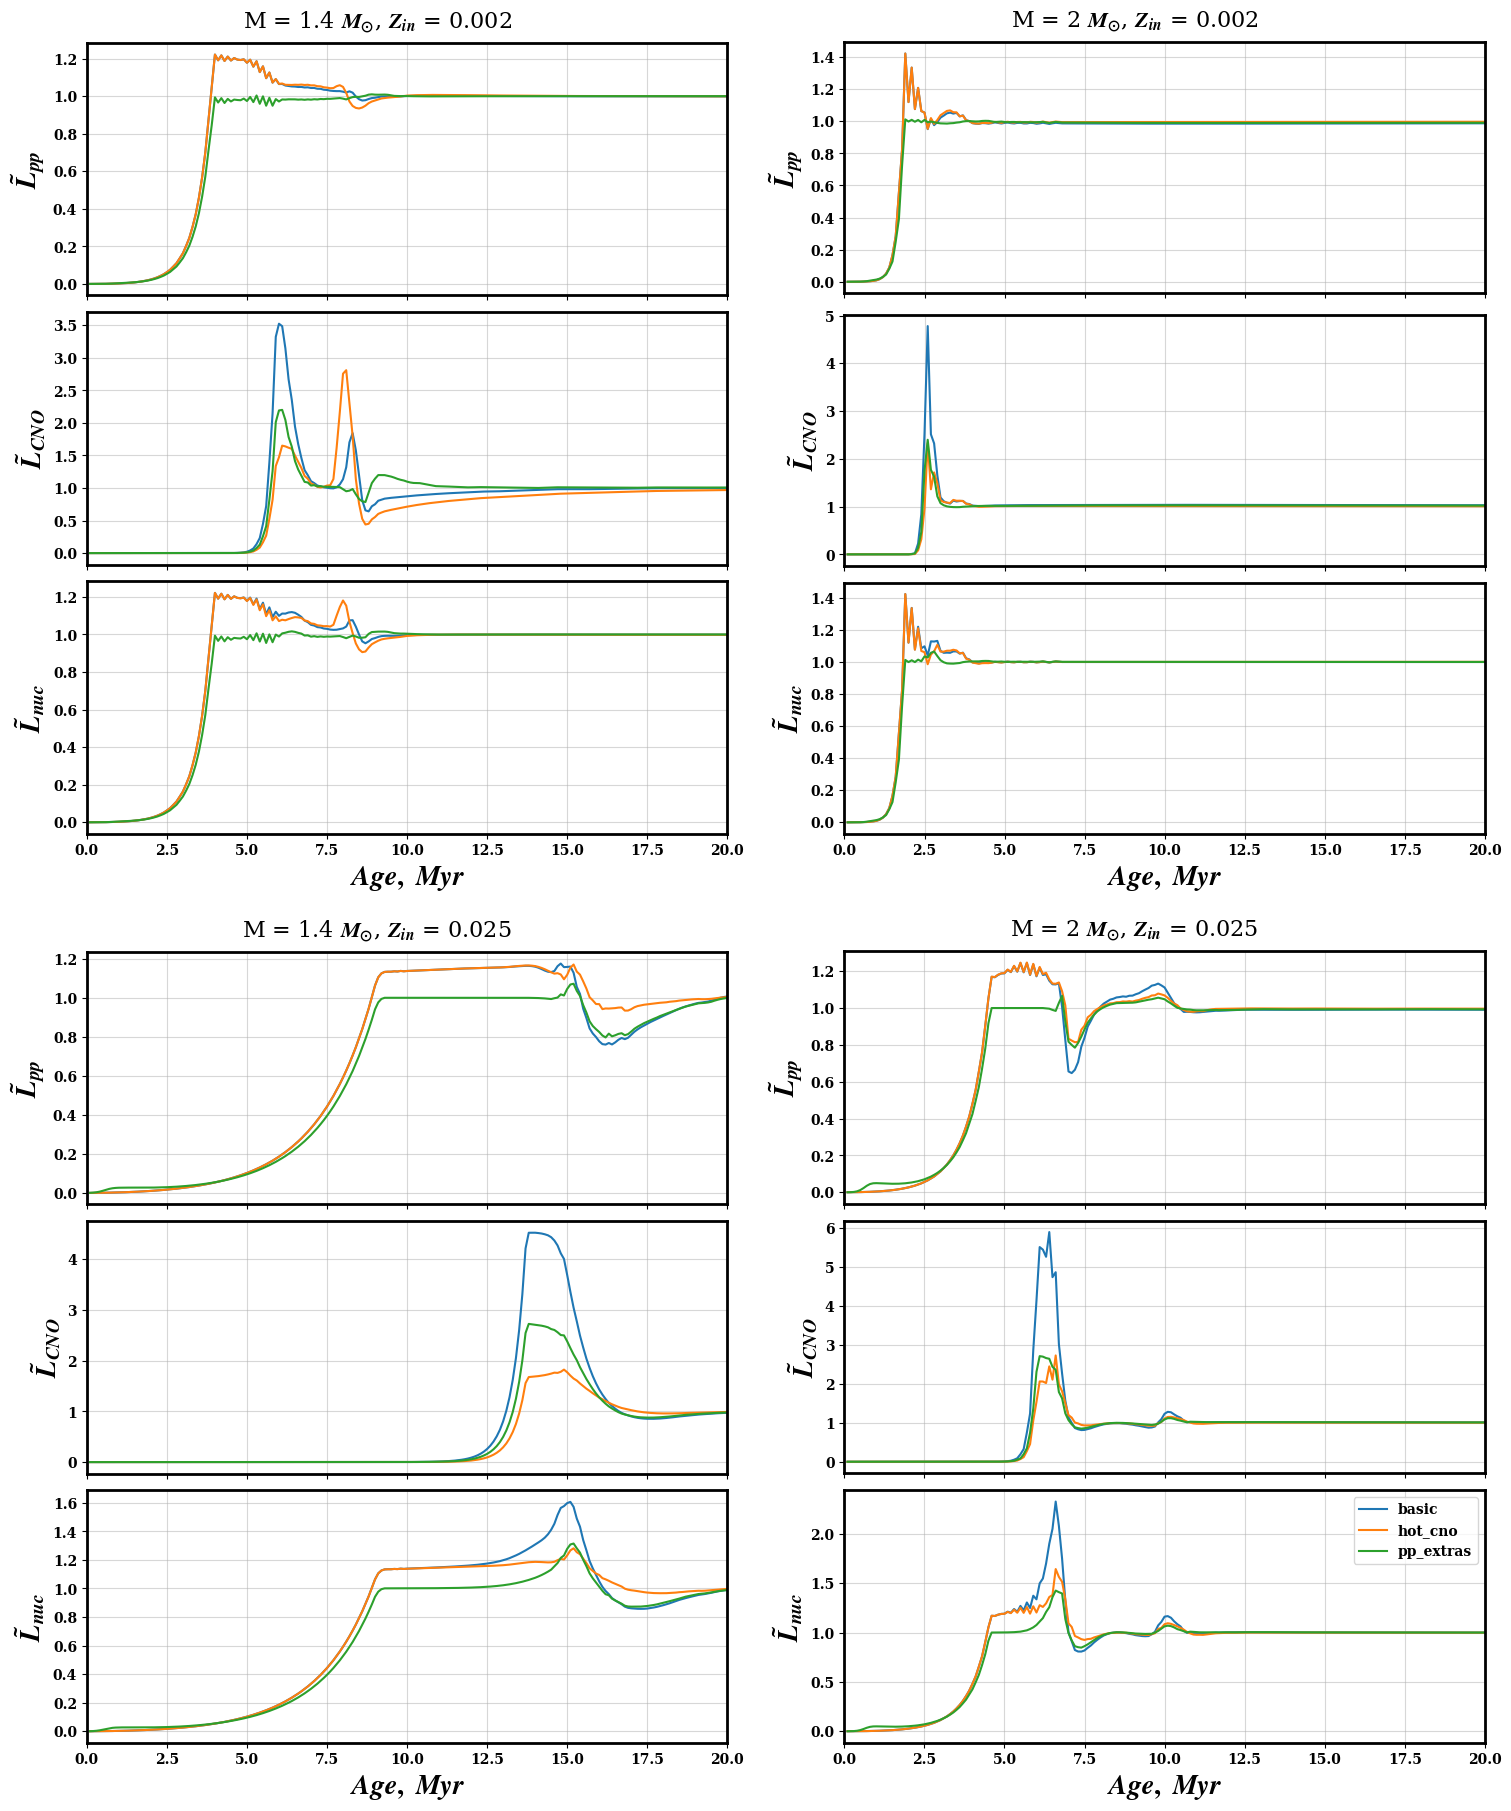

In [42]:
fig = plt.figure(constrained_layout=True, figsize=(15, 18))

subfigs = fig.subfigures(2, 2).flat

fig_names = [
    r"M = 1.4 $M_{\odot}$, $Z_{in}$ = 0.002",
    r"M = 2 $M_{\odot}$, $Z_{in}$ = 0.002",
    r"M = 1.4 $M_{\odot}$, $Z_{in}$ = 0.025",
    r"M = 2 $M_{\odot}$, $Z_{in}$ = 0.025"
]

axes = []
for o in range(4):
    subfigs[o].suptitle(fig_names[o], fontsize=16)
    axes.append(subfigs[o].subplots(3, 1))

nets = ["basic", "hot_cno", "pp_extras", "pp_and_cno_extras"]
age = np.arange(0, 40.1, 0.1)

cno_areas = {f"{m},{z}": [] for m in ["1.4", "2"] for z in ["0.002", "0.025"]}
pp_areas = {f"{m},{z}": [] for m in ["1.4", "2"] for z in ["0.002", "0.025"]}
for fig_name in fig_names:
    m, z = fig_name.split(",")[0].split("=")[1].split()[0], fig_name.split(",")[1].split("=")[1].split()[0]
    for net in nets:
        key = f"M={m}_Z={z}_V={0}_net={net}"
        # print(key)
        data = data_dict[key]
        norm_data = data_dict[f"M={m}_Z={z}_V={0}_net=pp_and_cno_extras"] 
        for i, ax in enumerate(axes[fig_names.index(fig_name)].flat):
            if i == 0 and net != "pp_and_cno_extras":
                L_pp = 10 ** np.array(data['pp'])
                L_norm = 10 ** np.array(norm_data['pp'])
                mask = L_norm < 1e-2
                L_norm[mask] = 1e-2
                L_pp = interp(data['age'], L_pp, age)
                L_norm = interp(norm_data['age'], L_norm, age)
                L_pp_norm = L_pp/L_norm
                area = np.trapz(L_pp_norm[1:], age[1:])
                ax.plot(age, L_pp_norm, label=f"{net}: {area:.3f}")
                ax.set_ylabel(r'$\tilde{L}_{pp}$', fontsize=20)
                ax.set_xticklabels([])
            elif i == 1 and net != "pp_and_cno_extras":
                L_cno = 10 ** np.array(data['cno'])
                L_norm = 10 ** np.array(norm_data['cno'])
                mask = L_norm < 1e-2
                L_norm[mask] = 1e-2
                L_cno = interp(data['age'], L_cno, age)
                L_norm = interp(norm_data['age'], L_norm, age)
                L_cno_norm = L_cno/L_norm
                area = np.trapz(L_cno_norm[1:], age[1:])
                ax.plot(age, L_cno_norm, label=f"{net}: {area:.3f}")
                ax.set_ylabel(r'$\tilde{L}_{CNO}$', fontsize=20)
                ax.set_xticklabels([])
            # elif i == 2 and net == "pp_and_cno_extras":
                # L_norm = 10 ** np.array(norm_data['cno'])
                # mask = L_norm < 1e-2
                # L_norm[mask] = 1e-2
                # L_norm = interp(norm_data['age'], L_norm, age)
                # ax.plot(age, L_norm, color="purple", label=f"{net}")
                # ax.set_ylabel(r'$L_{CNO,\ \rm{(pp\ and\ cno\ extras)}}$', fontsize=12)
                # ax.set_xlabel(r'$Age,\ Myr$', fontsize=10)
            elif i == 2 and net != "pp_and_cno_extras":
                L_nuc = 10 ** np.array(data['L_nuc'])
                L_norm = 10 ** np.array(norm_data['L_nuc'])
                mask = L_norm < 1e-2
                L_norm[mask] = 1e-2
                L_nuc = interp(data['age'], L_nuc, age)
                L_norm = interp(norm_data['age'], L_norm, age)
                L_nuc_norm = L_nuc/L_norm
                area_nuc = np.trapz(L_nuc_norm[1:], age[1:])
                # ax.plot(age, L_nuc_norm, label=f"{net}: {area_nuc:.3f}")
                ax.plot(age, L_nuc_norm, label=f"{net}")
                ax.set_ylabel(r'$\tilde{L}_{nuc}$', fontsize=20)
                ax.set_xlabel(r'$Age,\ Myr$', fontsize=20)
            ax.grid(alpha=0.5)
            if m == "1.4":
                ax.set_xlim(0, 20)
                # ax.set_ylim(0, 1000)
            elif m == "2":
                ax.set_xlim(0, 20)
                # ax.set_ylim(0, 1000)

# axes[3][0].legend()
axes[3][2].legend()
# for i in range(4):
#     for j in range(3):
#         axes[i][j].legend(title="Integrated Normalized Luminosity")

# plt.close()
plt.savefig("figures/net_comp_norm.png", dpi=300)
plt.show()

For low-M, high-Z

In [5]:
logs_dirs = sorted(glob.glob("test/m1.4_z0.025_*/LOGS"))
logs_dirs

['test/m1.36_z0.024_v0_netbasic/LOGS',
 'test/m1.36_z0.024_v0_netcno_extras/LOGS',
 'test/m1.36_z0.024_v0_nethot_cno/LOGS',
 'test/m1.36_z0.024_v0_netpp_and_cno_extras/LOGS',
 'test/m1.36_z0.024_v0_netpp_extras/LOGS']

In [7]:
import itertools

M_sample = [1.36]
Z_sample = [0.024]
V_sample = [0]
nets = ["basic", "cno_extras", "hot_cno", "pp_and_cno_extras", "pp_extras"]
combinations = list(itertools.product(M_sample, Z_sample, V_sample, nets))

data_dict = {}

k = 0
for m, z, v, net in combinations:
    print(m, z, v, net)
    key = f"M={m}_Z={z}_V={v}_net={net}"
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[k])
    models = [i[0] for i in prof_index if i[2] in n_profs]
    data_dict[key] = {}
    age_i = []
    cno_i = []
    pp_i = []
    eps_i = []
    dnu_i = []
    L_nuc_i = []
    density_i = []
    total_h1_mass_i = []
    total_he4_mass_i = []
    center_h1_i = []
    center_he4_i = []
    for i in range(len(freqs)):
        Dnu, epsilon = get_fit(0, freqs[i])
        eps_i.append(epsilon)
        age_i.append(hist[hist.model_number == models[i]]['star_age']/1e6)
        dnu_i.append(Dnu)
        cno_i.append(hist[hist.model_number == models[i]]['cno'].values[0])
        pp_i.append(hist[hist.model_number == models[i]]['pp'].values[0])
        L_nuc_i.append(hist[hist.model_number == models[i]]['log_Lnuc'].values[0])
        density_i.append(hist[hist.model_number == models[i]]['log_cntr_Rho'].values[0])
        center_h1_i.append(hist[hist.model_number == models[i]]['center_h1'].values[0])
        center_he4_i.append(hist[hist.model_number == models[i]]['center_he4'].values[0])
        total_h1_mass_i.append(hist[hist.model_number == models[i]]['total_mass_h1'].values[0])
        total_he4_mass_i.append(hist[hist.model_number == models[i]]['total_mass_he4'].values[0])
    data_dict[key]['age'] = age_i
    data_dict[key]['cno'] = cno_i
    data_dict[key]['pp'] = pp_i
    data_dict[key]['L_nuc'] = L_nuc_i
    data_dict[key]['dnu'] = dnu_i
    data_dict[key]['eps'] = eps_i
    data_dict[key]['density'] = density_i
    data_dict[key]['total_mass_h1'] = total_h1_mass_i
    data_dict[key]['total_mass_he4'] = total_he4_mass_i
    data_dict[key]['center_h1'] = center_h1_i
    data_dict[key]['center_he4'] = center_he4_i
    k += 1


1.36 0.024 0 basic
1.36 0.024 0 cno_extras
1.36 0.024 0 hot_cno
1.36 0.024 0 pp_and_cno_extras
1.36 0.024 0 pp_extras


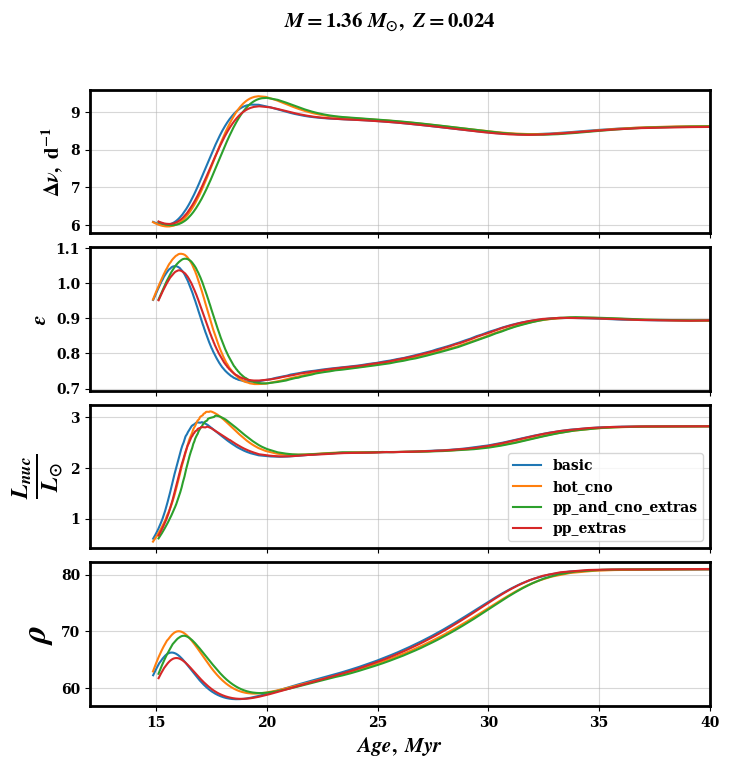

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8))
ax1 = axes[0]
ax2 = axes[1] 
ax3 = axes[2]
ax4 = axes[3]

nets = ["basic", "hot_cno", "pp_and_cno_extras", "pp_extras"]
i = 0
for net in nets:
    key = f"M={1.36}_Z={0.024}_V={0}_net={net}"
    age = data_dict[key]['age']
    # cno = data_dict[key]['cno']
    L_nuc = data_dict[key]['L_nuc']
    density = data_dict[key]['density']
    dnu = data_dict[key]['dnu']
    center_h1 = data_dict[key]['center_h1']
    eps = data_dict[key]['eps']
    ax1.plot(age, dnu, label = net)
    ax2.plot(age, eps, label = net)
    ax3.plot(age, 10**np.array(L_nuc), label = net)
    ax4.plot(age, 10**np.array(density), label = net)
    # ax4.plot(age, 10**np.array(center_h1), label = net)
    i += 1
ax1.set_ylabel(r'$\Delta\nu,\ \rm{d}^{-1}$', fontsize=15)
ax2.set_ylabel(r'$\epsilon$', fontsize=15)
ax3.set_ylabel(r'$\frac{L_{nuc}}{L_{\odot}}$', fontsize=25)
ax4.set_ylabel(r'$\rho}$', fontsize=25)
# ax4.set_ylabel("H1 abundance")
plt.xlabel(r'$Age,\ Myr$', fontsize=15)
xlim = (12,40)
ylim = (0, 10)
ax1.set_xlim(xlim[0], xlim[1])
ax2.set_xlim(xlim[0], xlim[1])
ax3.set_xlim(xlim[0], xlim[1])
ax4.set_xlim(xlim[0], xlim[1])
# ax1.set_ylim(ylim[0], ylim[1])
# ax2.set_ylim(ylim[0], ylim[1])
# ax3.set_ylim(ylim[0], ylim[1]*10)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0.1)
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax3.grid(alpha=0.5)
ax4.grid(alpha=0.5)
ax3.legend()
plt.suptitle(r'$M=1.36\ M_{\odot},\ Z=0.024$', fontsize=15)
# plt.savefig('test.png', dpi=300)
plt.show()

For low-M, low-Z

In [33]:
logs_dirs = sorted(glob.glob("test/m1.36_z0.001_*/LOGS"))
logs_dirs

['test/m1.36_z0.001_v0_netbasic/LOGS',
 'test/m1.36_z0.001_v0_netcno_extras/LOGS',
 'test/m1.36_z0.001_v0_nethot_cno/LOGS',
 'test/m1.36_z0.001_v0_netpp_and_cno_extras/LOGS',
 'test/m1.36_z0.001_v0_netpp_extras/LOGS']

In [35]:
import itertools

M_sample = [1.36]
Z_sample = [0.001]
V_sample = [0]
nets = ["basic", "cno_extras", "hot_cno", "pp_and_cno_extras", "pp_extras"]
combinations = list(itertools.product(M_sample, Z_sample, V_sample, nets))

data_dict = {}

k = 0
for m, z, v, net in combinations:
    print(m, z, v, net)
    key = f"M={m}_Z={z}_V={v}_net={net}"
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[k])
    models = [i[0] for i in prof_index if i[2] in n_profs]
    data_dict[key] = {}
    age_i = []
    cno_i = []
    pp_i = []
    eps_i = []
    dnu_i = []
    L_nuc_i = []
    density_i = []
    total_h1_mass_i = []
    total_he4_mass_i = []
    center_h1_i = []
    center_he4_i = []
    for i in range(len(freqs)):
        Dnu, epsilon = get_fit(0, freqs[i])
        eps_i.append(epsilon)
        age_i.append(hist[hist.model_number == models[i]]['star_age']/1e6)
        dnu_i.append(Dnu)
        cno_i.append(hist[hist.model_number == models[i]]['cno'].values[0])
        pp_i.append(hist[hist.model_number == models[i]]['pp'].values[0])
        L_nuc_i.append(hist[hist.model_number == models[i]]['log_Lnuc'].values[0])
        density_i.append(hist[hist.model_number == models[i]]['log_cntr_Rho'].values[0])
        center_h1_i.append(hist[hist.model_number == models[i]]['center_h1'].values[0])
        center_he4_i.append(hist[hist.model_number == models[i]]['center_he4'].values[0])
        total_h1_mass_i.append(hist[hist.model_number == models[i]]['total_mass_h1'].values[0])
        total_he4_mass_i.append(hist[hist.model_number == models[i]]['total_mass_he4'].values[0])
    data_dict[key]['age'] = age_i
    data_dict[key]['cno'] = cno_i
    data_dict[key]['pp'] = pp_i
    data_dict[key]['L_nuc'] = L_nuc_i
    data_dict[key]['dnu'] = dnu_i
    data_dict[key]['eps'] = eps_i
    data_dict[key]['density'] = density_i
    data_dict[key]['total_mass_h1'] = total_h1_mass_i
    data_dict[key]['total_mass_he4'] = total_he4_mass_i
    data_dict[key]['center_h1'] = center_h1_i
    data_dict[key]['center_he4'] = center_he4_i
    k += 1


1.36 0.001 0 basic
1.36 0.001 0 cno_extras
1.36 0.001 0 hot_cno
1.36 0.001 0 pp_and_cno_extras
1.36 0.001 0 pp_extras


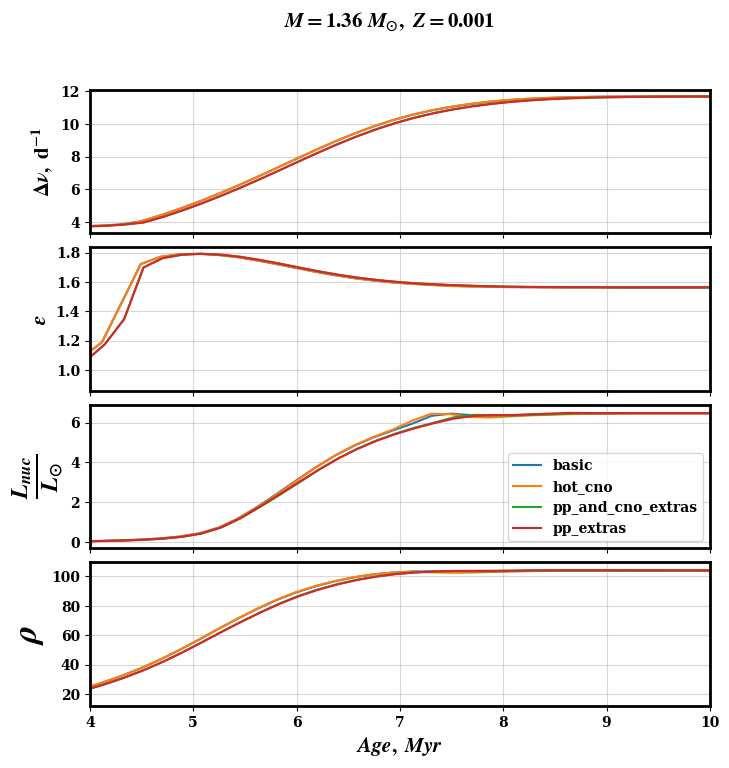

In [36]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8))
ax1 = axes[0]
ax2 = axes[1] 
ax3 = axes[2]
ax4 = axes[3]

nets = ["basic", "hot_cno", "pp_and_cno_extras", "pp_extras"]
i = 0
for net in nets:
    key = f"M={1.36}_Z={0.001}_V={0}_net={net}"
    age = data_dict[key]['age']
    # cno = data_dict[key]['cno']
    L_nuc = data_dict[key]['L_nuc']
    density = data_dict[key]['density']
    dnu = data_dict[key]['dnu']
    center_h1 = data_dict[key]['center_h1']
    eps = data_dict[key]['eps']
    ax1.plot(age, dnu, label = net)
    ax2.plot(age, eps, label = net)
    ax3.plot(age, 10**np.array(L_nuc), label = net)
    ax4.plot(age, 10**np.array(density), label = net)
    # ax4.plot(age, 10**np.array(center_h1), label = net)
    i += 1
ax1.set_ylabel(r'$\Delta\nu,\ \rm{d}^{-1}$', fontsize=15)
ax2.set_ylabel(r'$\epsilon$', fontsize=15)
ax3.set_ylabel(r'$\frac{L_{nuc}}{L_{\odot}}$', fontsize=25)
ax4.set_ylabel(r'$\rho}$', fontsize=25)
# ax4.set_ylabel("H1 abundance")
plt.xlabel(r'$Age,\ Myr$', fontsize=15)
xlim = (4, 10)
ylim = (0, 10)
ax1.set_xlim(xlim[0], xlim[1])
ax2.set_xlim(xlim[0], xlim[1])
ax3.set_xlim(xlim[0], xlim[1])
ax4.set_xlim(xlim[0], xlim[1])
# ax1.set_ylim(ylim[0], ylim[1])
# ax2.set_ylim(ylim[0], ylim[1])
# ax3.set_ylim(ylim[0], ylim[1]*10)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0.1)
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax3.grid(alpha=0.5)
ax4.grid(alpha=0.5)
ax3.legend()
plt.suptitle(r'$M=1.36\ M_{\odot},\ Z=0.001$', fontsize=15)
# plt.savefig('test.png', dpi=300)
plt.show()

Low_M_high_Z vs Low_M_low_Z

In [66]:
logs_dirs = sorted(glob.glob("test/m1.36_z0.024_*/LOGS"))
logs_dirs += sorted(glob.glob("test/m1.7_z0.024_*/LOGS"))
logs_dirs

['test/m1.36_z0.024_v0_netbasic/LOGS',
 'test/m1.36_z0.024_v0_netcno_extras/LOGS',
 'test/m1.36_z0.024_v0_nethot_cno/LOGS',
 'test/m1.36_z0.024_v0_netpp_and_cno_extras/LOGS',
 'test/m1.36_z0.024_v0_netpp_extras/LOGS',
 'test/m1.7_z0.024_v0_netbasic/LOGS',
 'test/m1.7_z0.024_v0_netcno_extras/LOGS',
 'test/m1.7_z0.024_v0_nethot_cno/LOGS',
 'test/m1.7_z0.024_v0_netpp_and_cno_extras/LOGS',
 'test/m1.7_z0.024_v0_netpp_extras/LOGS']

In [68]:
M_sample = [1.36, 1.7]
Z_sample = [0.024]
V_sample = [0]
nets = ["basic", "cno_extras", "hot_cno", "pp_and_cno_extras", "pp_extras"]

combinations = list(itertools.product(M_sample, Z_sample, V_sample, nets))

data_dict = {}

k = 0
for m, z, v, net in combinations:
    print(m, z, v, net)
    key = f"M={m}_Z={z}_V={v}_net={net}"
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[k])
    data_dict[key] = {}
    data_dict[key]['age'] = hist['star_age']/1e6
    data_dict[key]['cno'] = hist['cno'].values
    data_dict[key]['pp'] = hist['pp'].values
    data_dict[key]['L_nuc'] = hist['log_Lnuc'].values
    data_dict[key]['density'] = hist['log_cntr_Rho'].values
    data_dict[key]['delta_nu'] = hist['delta_nu'].values/11.5741
    data_dict[key]['nu_max'] = hist['nu_max'].values
    data_dict[key]['total_mass_h1'] = hist['total_mass_h1'].values
    data_dict[key]['total_mass_he4'] = hist['total_mass_he4'].values
    data_dict[key]['center_h1'] = hist['center_h1'].values
    data_dict[key]['center_he4'] = hist['center_he4'].values
    k += 1

1.36 0.024 0 basic
1.36 0.024 0 cno_extras
1.36 0.024 0 hot_cno
1.36 0.024 0 pp_and_cno_extras
1.36 0.024 0 pp_extras
1.7 0.024 0 basic
1.7 0.024 0 cno_extras
1.7 0.024 0 hot_cno
1.7 0.024 0 pp_and_cno_extras
1.7 0.024 0 pp_extras


KeyError: 'M=1.36_Z=0.024_V=0_net=pp_and_cno_extras'

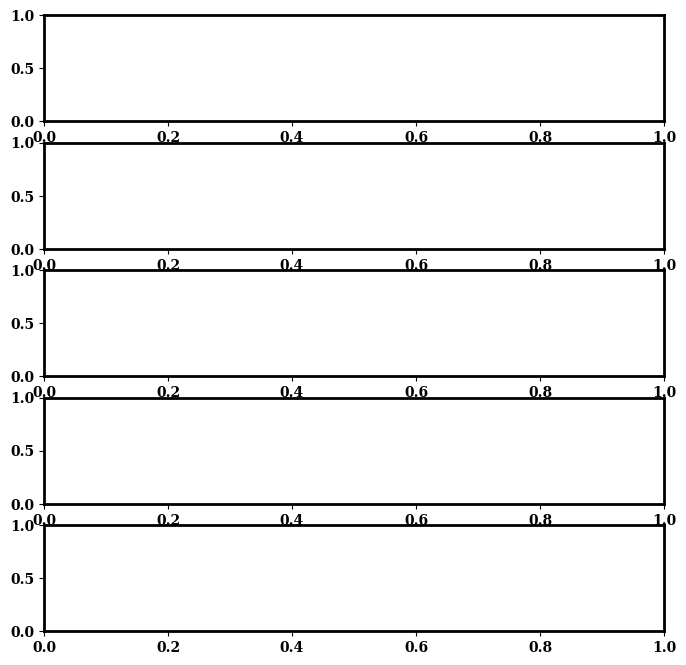

In [86]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 8))
ax1 = axes[0]
ax2 = axes[1] 
ax3 = axes[2]
ax4 = axes[3]
ax5 = axes[4]
# nets = ["basic", "hot_cno", "pp_and_cno_extras", "pp_extras"]
i = 0
net = "pp_and_cno_extras"
M_sample = [1.36, 1.7]
Z_sample = [0.024]
for M, Z in itertools.product(M_sample, Z_sample):
    key = f"M={M}_Z={Z}_V={0}_net={net}"
    age = data_dict[key]['age']
    L_nuc = data_dict[key]['L_nuc']
    density = data_dict[key]['density']
    dnu = data_dict[key]['delta_nu']
    pp = data_dict[key]['pp']
    cno = data_dict[key]['cno']
    ax1.plot(age, dnu, label = net)
    ax2.plot(age, 10**np.array(L_nuc), label=f"M = {M}, Z = {Z}")
    ax3.plot(age, 10**np.array(cno), label=f"M = {M}, Z = {Z}")
    ax4.plot(age, 10**np.array(pp), label=f"M = {M}, Z = {Z}")
    ax5.plot(age, 10**np.array(density), label=f"M = {M}, Z = {Z}")
    i += 1
ax1.set_ylabel(r'$\Delta\nu,\ \rm{d}^{-1}$', fontsize=15)
ax2.set_ylabel(r'$\frac{L_{nuc}}{L_{\odot}}$', fontsize=25)
ax3.set_ylabel(r'$\frac{L_{CNO}}{L_\odot}$', fontsize=25)
ax4.set_ylabel(r'$\frac{L_{pp}}{L_\odot}$', fontsize=25)
ax5.set_ylabel(r'$\rho}$', fontsize=25)

plt.xlabel(r'$Age,\ Myr$', fontsize=15)
xlim = (1, 25)
ylim = (0, 10)
ax1.set_xlim(xlim[0], xlim[1])
ax2.set_xlim(xlim[0], xlim[1])
ax3.set_xlim(xlim[0], xlim[1])
ax4.set_xlim(xlim[0], xlim[1])
ax5.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1]*1)
ax2.set_ylim(ylim[0], ylim[1]*1)
ax3.set_ylim(ylim[0], ylim[1]*0.75)
ax4.set_ylim(ylim[0], ylim[1]*1)
ax5.set_ylim(ylim[0], ylim[1]*12)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0.1)
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax3.grid(alpha=0.5)
ax4.grid(alpha=0.5)
ax5.grid(alpha=0.5)
ax5.legend()
# plt.suptitle(r'$M=1.36\ M_{\odot}$', fontsize=15)
plt.savefig('test.png', dpi=300)
plt.show()

In [78]:
logs_dirs = sorted(glob.glob("test/test_M*_Z0.024/LOGS"))
logs_dirs

['test/test_M1.36_Z0.024/LOGS',
 'test/test_M1.4000000000000001_Z0.024/LOGS',
 'test/test_M1.4400000000000002_Z0.024/LOGS',
 'test/test_M1.4800000000000002_Z0.024/LOGS',
 'test/test_M1.5200000000000002_Z0.024/LOGS',
 'test/test_M1.5600000000000003_Z0.024/LOGS',
 'test/test_M1.6000000000000003_Z0.024/LOGS',
 'test/test_M1.6400000000000003_Z0.024/LOGS',
 'test/test_M1.6800000000000004_Z0.024/LOGS',
 'test/test_M1.7200000000000004_Z0.024/LOGS',
 'test/test_M1.7600000000000005_Z0.024/LOGS',
 'test/test_M1.8000000000000005_Z0.024/LOGS',
 'test/test_M1.8400000000000005_Z0.024/LOGS',
 'test/test_M1.8800000000000006_Z0.024/LOGS',
 'test/test_M1.9200000000000006_Z0.024/LOGS',
 'test/test_M1.9600000000000006_Z0.024/LOGS']

In [89]:
M_sample = np.arange(1.36, 2, 0.04)
Z_sample = [0.024]
V_sample = 0

combinations = list(itertools.product(M_sample, Z_sample))

data_dict = {}

k = 0
for m, z in combinations:
    print(m, z)
    key = f"M={m:0.2f}_Z={z}"
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[k])
    data_dict[key] = {}
    data_dict[key]['age'] = hist['star_age']/1e6
    data_dict[key]['cno'] = hist['cno'].values
    data_dict[key]['pp'] = hist['pp'].values
    data_dict[key]['L_nuc'] = hist['log_Lnuc'].values
    data_dict[key]['density'] = hist['log_cntr_Rho'].values
    data_dict[key]['delta_nu'] = hist['delta_nu'].values/11.5741
    data_dict[key]['nu_max'] = hist['nu_max'].values
    data_dict[key]['total_mass_h1'] = hist['total_mass_h1'].values
    data_dict[key]['total_mass_he4'] = hist['total_mass_he4'].values
    data_dict[key]['center_h1'] = hist['center_h1'].values
    data_dict[key]['center_he4'] = hist['center_he4'].values
    k += 1

1.36 0.024
1.4000000000000001 0.024
1.4400000000000002 0.024
1.4800000000000002 0.024
1.5200000000000002 0.024
1.5600000000000003 0.024
1.6000000000000003 0.024
1.6400000000000003 0.024
1.6800000000000004 0.024
1.7200000000000004 0.024
1.7600000000000005 0.024
1.8000000000000005 0.024
1.8400000000000005 0.024
1.8800000000000006 0.024
1.9200000000000006 0.024
1.9600000000000006 0.024


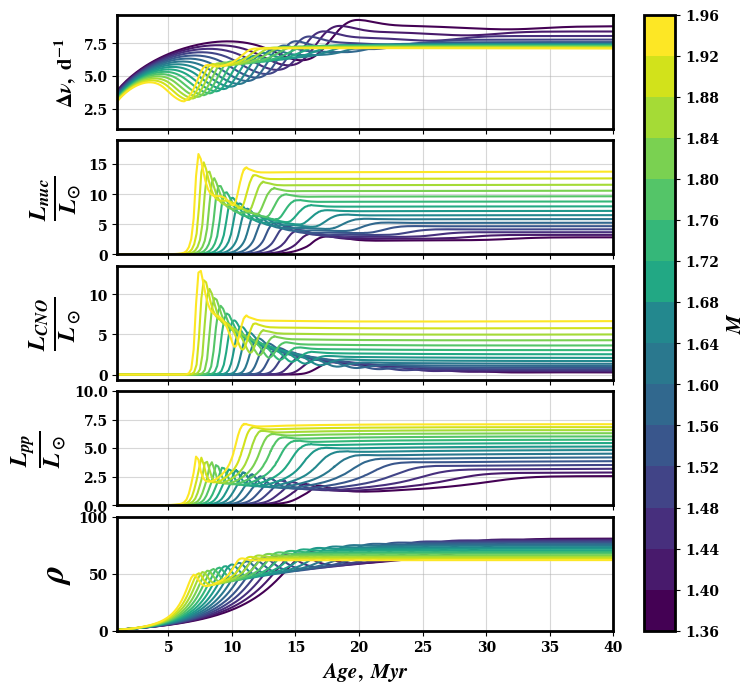

In [102]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 8))
cmap = plt.cm.get_cmap('viridis', len(M_sample))
ax1 = axes[0]
ax2 = axes[1] 
ax3 = axes[2]
ax4 = axes[3]
ax5 = axes[4]
i = 0
for M, Z in itertools.product(M_sample, Z_sample):
    key = f"M={M:0.2f}_Z={Z}"
    age = data_dict[key]['age']
    L_nuc = data_dict[key]['L_nuc']
    density = data_dict[key]['density']
    dnu = data_dict[key]['delta_nu']
    pp = data_dict[key]['pp']
    cno = data_dict[key]['cno']
    ax1.plot(age, dnu, label = net, color=cmap(i))
    ax2.plot(age, 10**np.array(L_nuc), label=f"M = {M}, Z = {Z}", color=cmap(i))
    ax3.plot(age, 10**np.array(cno), label=f"M = {M}, Z = {Z}", color=cmap(i))
    ax4.plot(age, 10**np.array(pp), label=f"M = {M}, Z = {Z}", color=cmap(i))
    ax5.plot(age, 10**np.array(density), label=f"M = {M}, Z = {Z}", color=cmap(i))
    i += 1
ax1.set_ylabel(r'$\Delta\nu,\ \rm{d}^{-1}$', fontsize=15)
ax2.set_ylabel(r'$\frac{L_{nuc}}{L_{\odot}}$', fontsize=25)
ax3.set_ylabel(r'$\frac{L_{CNO}}{L_\odot}$', fontsize=25)
ax4.set_ylabel(r'$\frac{L_{pp}}{L_\odot}$', fontsize=25)
ax5.set_ylabel(r'$\rho}$', fontsize=25)

plt.xlabel(r'$Age,\ Myr$', fontsize=15)
xlim = (1, 40)
ylim = (0, 10)
ax1.set_xlim(xlim[0], xlim[1])
ax2.set_xlim(xlim[0], xlim[1])
ax3.set_xlim(xlim[0], xlim[1])
ax4.set_xlim(xlim[0], xlim[1])
ax5.set_xlim(xlim[0], xlim[1])
# ax1.set_ylim(ylim[0], ylim[1]*1)
ax2.set_ylim(ylim[0], ylim[1]*1.9)
# ax3.set_ylim(ylim[0], ylim[1]*0.75)
ax4.set_ylim(ylim[0], ylim[1]*1)
# ax5.set_ylim(ylim[0], ylim[1]*12)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0.1)
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax3.grid(alpha=0.5)
ax4.grid(alpha=0.5)
ax5.grid(alpha=0.5)


z = [[0,0],[0,0]]
M_in = [float(f"{m:0.2f}") for m in M_sample]
levels = M_in
contour = plt.contourf(z, levels, cmap=cmap)
cb = fig.colorbar(contour, ticks=M_in, 
                boundaries=np.arange(len(M_in)+1)-0.5, ax=axes.ravel().tolist())
cb.set_label(label=r'$M$', size=15, weight='bold')
# ax5.legend()
# plt.suptitle(r'$M=1.36\ M_{\odot}$', fontsize=15)
# plt.savefig('test.png', dpi=300)
plt.show()

In [134]:
logs_dirs = sorted(glob.glob("test/test_M*_Z0.024/LOGS"))
logs_dirs

['test/test_M1.36_Z0.024/LOGS',
 'test/test_M1.37_Z0.024/LOGS',
 'test/test_M1.4000000000000001_Z0.024/LOGS',
 'test/test_M1.4100000000000001_Z0.024/LOGS',
 'test/test_M1.4400000000000002_Z0.024/LOGS',
 'test/test_M1.4500000000000002_Z0.024/LOGS',
 'test/test_M1.4800000000000002_Z0.024/LOGS',
 'test/test_M1.4900000000000002_Z0.024/LOGS',
 'test/test_M1.5200000000000002_Z0.024/LOGS',
 'test/test_M1.5300000000000002_Z0.024/LOGS',
 'test/test_M1.5600000000000003_Z0.024/LOGS',
 'test/test_M1.5700000000000003_Z0.024/LOGS',
 'test/test_M1.6000000000000003_Z0.024/LOGS',
 'test/test_M1.6100000000000003_Z0.024/LOGS',
 'test/test_M1.6400000000000003_Z0.024/LOGS',
 'test/test_M1.6500000000000004_Z0.024/LOGS',
 'test/test_M1.6800000000000004_Z0.024/LOGS',
 'test/test_M1.6900000000000004_Z0.024/LOGS',
 'test/test_M1.7200000000000004_Z0.024/LOGS',
 'test/test_M1.7300000000000004_Z0.024/LOGS',
 'test/test_M1.7600000000000005_Z0.024/LOGS',
 'test/test_M1.7700000000000005_Z0.024/LOGS',
 'test/test_M1.8

In [107]:
combinations = list(itertools.product(M_sample, Z_sample))

data_dict = {}

k = 0
for m, z in combinations:
    print(m, z)
    key = f"M={m:0.2f}_Z={z}"
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[k])
    models = [i[0] for i in prof_index if i[2] in n_profs]
    data_dict[key] = {}
    age_i = []
    cno_i = []
    pp_i = []
    eps_i = []
    dnu_i = []
    L_nuc_i = []
    density_i = []
    for i in range(len(freqs)):
        Dnu, epsilon = get_fit(0, freqs[i])
        eps_i.append(epsilon)
        age_i.append(hist[hist.model_number == models[i]]['star_age']/1e6)
        dnu_i.append(Dnu)
        cno_i.append(hist[hist.model_number == models[i]]['cno'].values[0])
        pp_i.append(hist[hist.model_number == models[i]]['pp'].values[0])
        L_nuc_i.append(hist[hist.model_number == models[i]]['log_Lnuc'].values[0])
        density_i.append(hist[hist.model_number == models[i]]['log_cntr_Rho'].values[0])
    data_dict[key]['age'] = age_i
    data_dict[key]['cno'] = cno_i
    data_dict[key]['pp'] = pp_i
    data_dict[key]['L_nuc'] = L_nuc_i
    data_dict[key]['dnu'] = dnu_i
    data_dict[key]['eps'] = eps_i
    data_dict[key]['density'] = density_i
    k += 1


1.36 0.024
1.4000000000000001 0.024
1.4400000000000002 0.024
1.4800000000000002 0.024
1.5200000000000002 0.024
1.5600000000000003 0.024
1.6000000000000003 0.024
1.6400000000000003 0.024
1.6800000000000004 0.024
1.7200000000000004 0.024
1.7600000000000005 0.024
1.8000000000000005 0.024
1.8400000000000005 0.024
1.8800000000000006 0.024
1.9200000000000006 0.024
1.9600000000000006 0.024


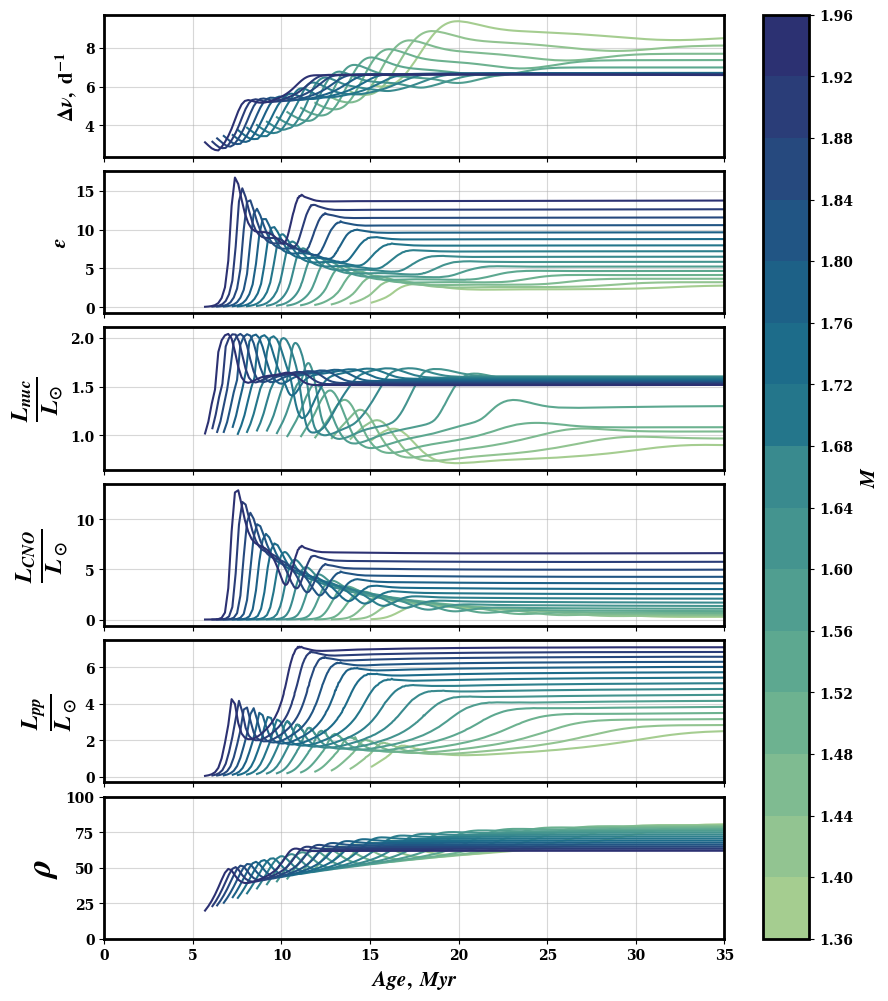

In [116]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 12))
cmap = plt.cm.get_cmap('crest', len(M_sample))
ax1 = axes[0]
ax2 = axes[1] 
ax3 = axes[2]
ax4 = axes[3]
ax5 = axes[4]
ax6 = axes[5]
i = 0
for M, Z in itertools.product(M_sample, Z_sample):
    key = f"M={M:0.2f}_Z={Z}"
    age = data_dict[key]['age']
    L_nuc = data_dict[key]['L_nuc']
    density = data_dict[key]['density']
    dnu = data_dict[key]['dnu']
    eps = data_dict[key]['eps']
    pp = data_dict[key]['pp']
    cno = data_dict[key]['cno']
    ax1.plot(age, dnu, label = net, color=cmap(i))
    ax2.plot(age, 10**np.array(L_nuc), label=f"M = {M}, Z = {Z}", color=cmap(i))
    ax3.plot(age, eps, label=f"M = {M}, Z = {Z}", color=cmap(i))
    ax4.plot(age, 10**np.array(cno), label=f"M = {M}, Z = {Z}", color=cmap(i))
    ax5.plot(age, 10**np.array(pp), label=f"M = {M}, Z = {Z}", color=cmap(i))
    ax6.plot(age, 10**np.array(density), label=f"M = {M}, Z = {Z}", color=cmap(i))
    i += 1
ax1.set_ylabel(r'$\Delta\nu,\ \rm{d}^{-1}$', fontsize=15)
ax2.set_ylabel(r'$\epsilon$', fontsize=15)
ax3.set_ylabel(r'$\frac{L_{nuc}}{L_{\odot}}$', fontsize=25)
ax4.set_ylabel(r'$\frac{L_{CNO}}{L_\odot}$', fontsize=25)
ax5.set_ylabel(r'$\frac{L_{pp}}{L_\odot}$', fontsize=25)
ax6.set_ylabel(r'$\rho}$', fontsize=25)

plt.xlabel(r'$Age,\ Myr$', fontsize=15)
xlim = (0, 35)
ax1.set_xlim(xlim[0], xlim[1])
ax2.set_xlim(xlim[0], xlim[1])
ax3.set_xlim(xlim[0], xlim[1])
ax4.set_xlim(xlim[0], xlim[1])
ax5.set_xlim(xlim[0], xlim[1])
ax6.set_xlim(xlim[0], xlim[1])
ylim = (0, 10)
# ax1.set_ylim(ylim[0], ylim[1]*1)
# ax2.set_ylim(ylim[0], ylim[1]*1.9)
# ax3.set_ylim(ylim[0], ylim[1]*0.75)
# ax4.set_ylim(ylim[0], ylim[1]*1)
# ax5.set_ylim(ylim[0], ylim[1]*12)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0.1)
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax3.grid(alpha=0.5)
ax4.grid(alpha=0.5)
ax5.grid(alpha=0.5)
ax6.grid(alpha=0.5)

z = [[0,0],[0,0]]
M_in = [float(f"{m:0.2f}") for m in M_sample]
levels = M_in
contour = plt.contourf(z, levels, cmap=cmap)
cb = fig.colorbar(contour, ticks=M_in, 
                boundaries=np.arange(len(M_in)+1)-0.5, ax=axes.ravel().tolist())
cb.set_label(label=r'$M$', size=15, weight='bold')
# ax5.legend()
# plt.suptitle(r'$M=1.36\ M_{\odot}$', fontsize=15)
# plt.savefig('test.png', dpi=300)
plt.show()

In [23]:
logs_dirs = sorted(glob.glob("test/m*_z0.024_*/LOGS"))
logs_dirs

['test/m1.45_z0.024_v0_netbasic/LOGS',
 'test/m1.45_z0.024_v0_nethot_cno/LOGS',
 'test/m1.45_z0.024_v0_netpp_and_cno_extras/LOGS',
 'test/m1.45_z0.024_v0_netpp_extras/LOGS',
 'test/m1.4_z0.024_v0_netbasic/LOGS',
 'test/m1.4_z0.024_v0_nethot_cno/LOGS',
 'test/m1.4_z0.024_v0_netpp_and_cno_extras/LOGS',
 'test/m1.4_z0.024_v0_netpp_extras/LOGS',
 'test/m1.55_z0.024_v0_netbasic/LOGS',
 'test/m1.55_z0.024_v0_nethot_cno/LOGS',
 'test/m1.55_z0.024_v0_netpp_and_cno_extras/LOGS',
 'test/m1.55_z0.024_v0_netpp_extras/LOGS',
 'test/m1.5_z0.024_v0_netbasic/LOGS',
 'test/m1.5_z0.024_v0_nethot_cno/LOGS',
 'test/m1.5_z0.024_v0_netpp_and_cno_extras/LOGS',
 'test/m1.5_z0.024_v0_netpp_extras/LOGS',
 'test/m1.6500000000000001_z0.024_v0_netbasic/LOGS',
 'test/m1.6500000000000001_z0.024_v0_nethot_cno/LOGS',
 'test/m1.6500000000000001_z0.024_v0_netpp_and_cno_extras/LOGS',
 'test/m1.6500000000000001_z0.024_v0_netpp_extras/LOGS',
 'test/m1.6_z0.024_v0_netbasic/LOGS',
 'test/m1.6_z0.024_v0_nethot_cno/LOGS',
 'te

In [36]:
M_sample = sorted(list(set([float(logs_dir.split('_')[0][6:10]) for logs_dir in logs_dirs])))
Z_sample = [0.024]
M_sample

[1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0]

In [34]:
nets = ["basic", "hot_cno", "pp_and_cno_extras", "pp_extras"]
combinations = list(itertools.product(M_sample, Z_sample, nets))

data_dict = {}

k = 0
for m, z, net in combinations:
    print(m, z, net)
    key = f"M={m:0.2f}_Z={z}_net={net}"
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[k])
    models = [i[0] for i in prof_index if i[2] in n_profs]
    data_dict[key] = {}
    age_i = []
    cno_i = []
    pp_i = []
    eps_i = []
    dnu_i = []
    L_nuc_i = []
    density_i = []
    for i in range(len(freqs)):
        Dnu, epsilon = get_fit(0, freqs[i])
        eps_i.append(epsilon)
        age_i.append(hist[hist.model_number == models[i]]['star_age']/1e6)
        dnu_i.append(Dnu)
        cno_i.append(hist[hist.model_number == models[i]]['cno'].values[0])
        pp_i.append(hist[hist.model_number == models[i]]['pp'].values[0])
        L_nuc_i.append(hist[hist.model_number == models[i]]['log_Lnuc'].values[0])
        density_i.append(hist[hist.model_number == models[i]]['log_cntr_Rho'].values[0])
    data_dict[key]['age'] = age_i
    data_dict[key]['cno'] = cno_i
    data_dict[key]['pp'] = pp_i
    data_dict[key]['L_nuc'] = L_nuc_i
    data_dict[key]['dnu'] = dnu_i
    data_dict[key]['eps'] = eps_i
    data_dict[key]['density'] = density_i
    k += 1

1.4 0.024 basic
1.4 0.024 hot_cno
1.4 0.024 pp_and_cno_extras
1.4 0.024 pp_extras
1.6 0.024 basic
1.6 0.024 hot_cno
1.6 0.024 pp_and_cno_extras
1.6 0.024 pp_extras
1.55 0.024 basic
1.55 0.024 hot_cno
1.55 0.024 pp_and_cno_extras
1.55 0.024 pp_extras
1.45 0.024 basic
1.45 0.024 hot_cno
1.45 0.024 pp_and_cno_extras
1.45 0.024 pp_extras
1.5 0.024 basic
1.5 0.024 hot_cno
1.5 0.024 pp_and_cno_extras
1.5 0.024 pp_extras
1.65 0.024 basic
1.65 0.024 hot_cno
1.65 0.024 pp_and_cno_extras
1.65 0.024 pp_extras
1.7 0.024 basic
1.7 0.024 hot_cno
1.7 0.024 pp_and_cno_extras
1.7 0.024 pp_extras
1.75 0.024 basic
1.75 0.024 hot_cno
1.75 0.024 pp_and_cno_extras
1.75 0.024 pp_extras
1.8 0.024 basic
1.8 0.024 hot_cno
1.8 0.024 pp_and_cno_extras
1.8 0.024 pp_extras
1.85 0.024 basic
1.85 0.024 hot_cno
1.85 0.024 pp_and_cno_extras
1.85 0.024 pp_extras
1.9 0.024 basic
1.9 0.024 hot_cno
1.9 0.024 pp_and_cno_extras
1.9 0.024 pp_extras
2.0 0.024 basic
2.0 0.024 hot_cno
2.0 0.024 pp_and_cno_extras
2.0 0.024 pp_ext

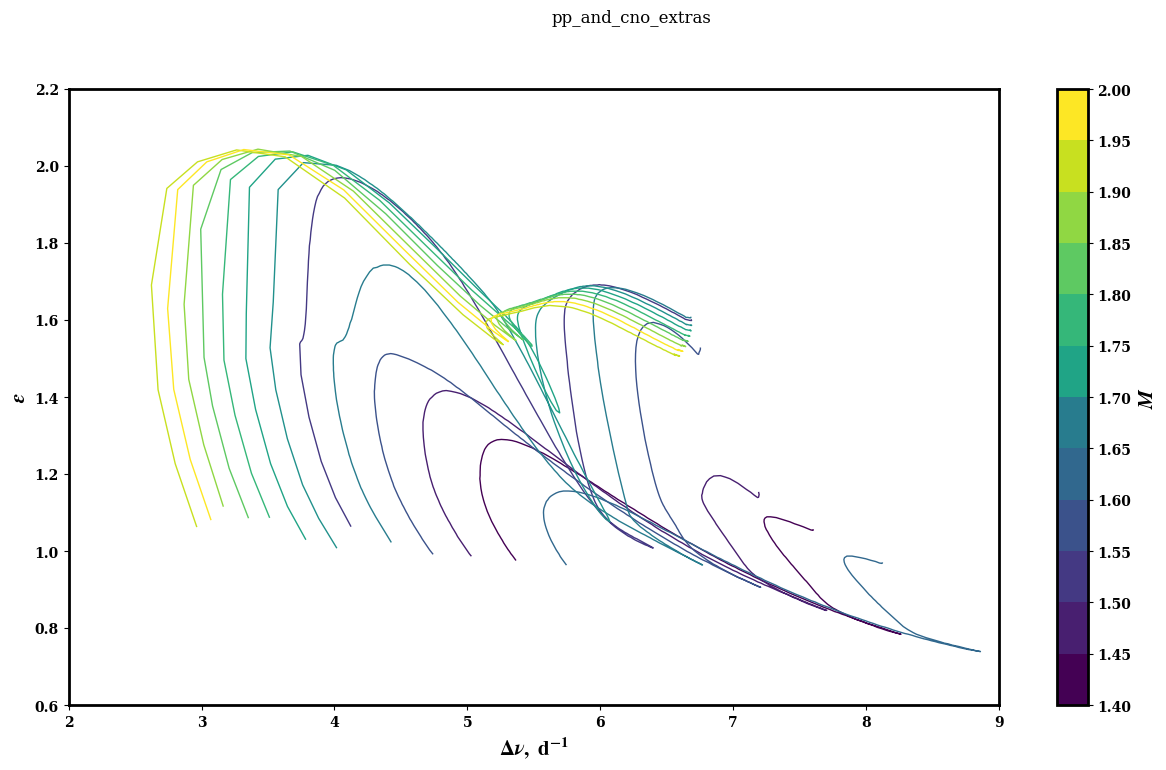

In [56]:
net = "pp_and_cno_extras"
fig = plt.figure(figsize=(15, 8))
cmap = plt.cm.get_cmap('viridis', len(M_sample))
i = 0
for M, Z in itertools.product(M_sample, Z_sample):
    key = f"M={M:0.2f}_Z={Z}_net={net}"
    dnu = data_dict[key]['dnu']
    eps = data_dict[key]['eps']
    plt.plot(dnu, eps, "-", color=cmap(i), lw=1)
    i += 1
plt.xlabel(r'$\Delta\nu,\ \rm{d}^{-1}$', fontsize=15)
plt.ylabel(r'$\epsilon$', fontsize=15)
plt.xlim(2, 9)
plt.ylim(0.6, 2.2)
z = [[0,0],[0,0]]
M_in = [float(f"{m:0.2f}") for m in M_sample]
levels = M_in
contour = plt.contourf(z, levels, cmap=cmap)
cb = fig.colorbar(contour, ticks=M_in, 
                boundaries=np.arange(len(M_in)+1)-0.5)
cb.set_label(label=r'$M$', size=15, weight='bold')
plt.suptitle(net)
plt.savefig(f'{net}.png', dpi=500)